In [1]:
#导入库
import numpy as np
import tensorflow as tf
import scipy.io as sio
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#设置参数
#style权重和content权重可以控制结果是趋于风格还是趋于内容
STYLE_WEIGHT=1.5
CONTENT_WEIGHT=1
#style的层数越多，就越能挖掘更多的风格特征，content的层数越深，得到的特征越抽象
STYLE_LAYERS=['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
CONTENT_LAYERS=['relu4_2', 'relu5_2']
VGG_PATH = 'imagenet-vgg-verydeep-19.mat'
#VGG模型结构
VGG_LAYERS=(
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4','pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    )
POOL_TYPE='max'

In [3]:
#定义vgg网络
def net_vgg19(input_image,layers,vgg_path,pool_type='max'):
    weights=sio.loadmat(vgg_path)['layers'][0]
    net=input_image
    network={}
    for i,name in enumerate(layers):
        layer_type=name[:4]
        if layer_type=='conv':
            kernels,bias=weights[i][0][0][0][0]
            kernels=np.transpose(kernels,(1,0,2,3))
            conv=tf.nn.conv2d(net,tf.constant(kernels),strides=(1,1,1,1),padding='SAME',name=name)
            net=tf.nn.bias_add(conv,bias.reshape(-1))
            net=tf.nn.relu(net)
        elif layer_type=='pool':
            if pool_type == 'avg':
                net=tf.nn.avg_pool(net, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),padding='SAME')
            else:
                net=tf.nn.max_pool(net, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),padding='SAME')
            
        network[name]=net
        
    return network

In [4]:
#定义损失误差
def loss_function(style_image,content_image,target_image):
    style_features=net_vgg19([style_image],VGG_LAYERS,VGG_PATH,POOL_TYPE)
    content_features=net_vgg19([content_image],VGG_LAYERS,VGG_PATH,POOL_TYPE)
    target_features=net_vgg19([target_image],VGG_LAYERS,VGG_PATH,POOL_TYPE)
    
    loss=0.0
    
    for layer in CONTENT_LAYERS:
        _,height,width,channel=map(lambda i:i.value,content_features[layer].get_shape())
        content_size=height*width*channel
        loss_content=tf.nn.l2_loss(target_features[layer]-content_features[layer])/content_size
        loss+=CONTENT_WEIGHT*loss_content
        
    for layer in STYLE_LAYERS:
        target_feature=target_features[layer]
        style_feature=style_features[layer]
        
        _,height,width,channel=map(lambda i:i.value,target_feature.get_shape())
    
        style_size=height*width*channel
        target_feature=tf.reshape(target_feature,(-1,channel))
        target_gram=tf.matmul(tf.transpose(target_feature),target_feature)/style_size
    
        style_feature=tf.reshape(style_feature,(-1,channel))
        style_gram=tf.matmul(tf.transpose(style_feature),style_feature)/style_size
    
        loss_style=tf.nn.l2_loss(target_gram-style_gram)/style_size
    
        loss+=STYLE_WEIGHT*loss_style
        
    return loss

In [5]:
#定义stylize函数,进行训练
def stylize(style_image,content_image,learning_rate=0.1,epochs=100):
    
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32)
    style_input = tf.constant(style_image,dtype=tf.float32)
    content_input = tf.constant(content_image, dtype=tf.float32)
    
    cost=loss_function(style_input,content_input,target)
    #定义优化器
    train=tf.train.AdamOptimizer(learning_rate).minimize(cost)
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.global_variables_initializer().run()
        for i in range(epochs):
            _,loss,target_img=sess.run([train,cost,target])
            
            if(i+1)%100==0:
                print('迭代: %d ,loss: %.8f'%(i+1,loss))
                image=np.clip(target_img+128,0,255).astype(np.uint8)
                img=Image.fromarray(image)
                plt.imshow(img)
                plt.axis('on')
                plt.title('Image')
                plt.show()

迭代: 100 ,loss: 34457.41796875


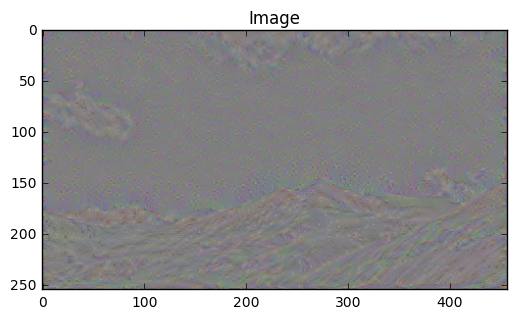

迭代: 200 ,loss: 22392.68164062


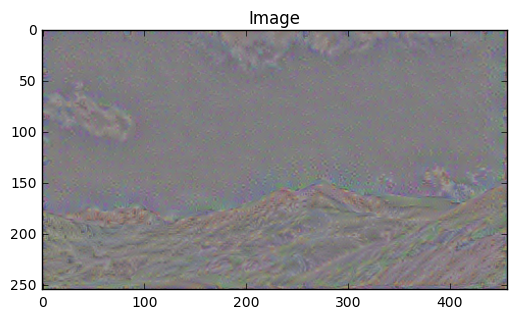

迭代: 300 ,loss: 17416.27929688


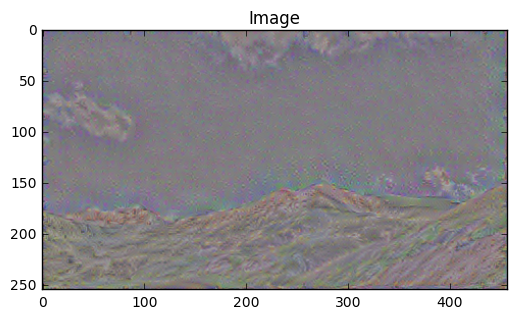

迭代: 400 ,loss: 14700.94433594


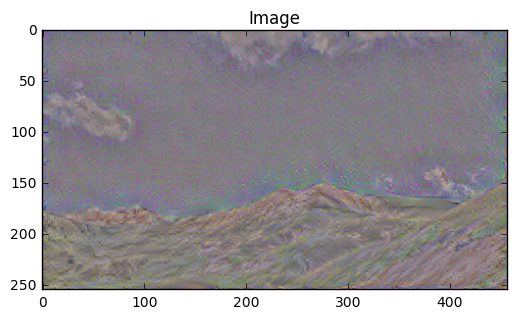

迭代: 500 ,loss: 13037.95214844


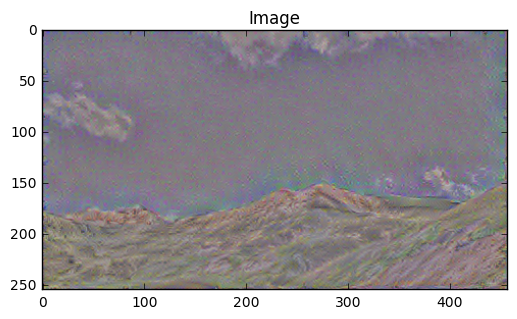

迭代: 600 ,loss: 11885.32812500


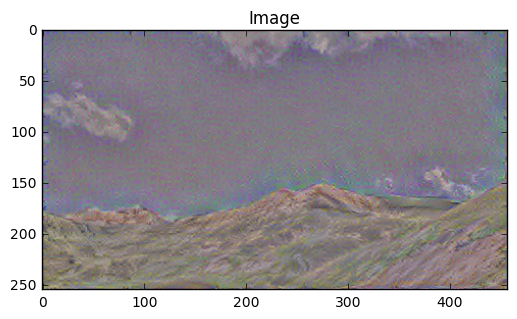

迭代: 700 ,loss: 11039.56933594


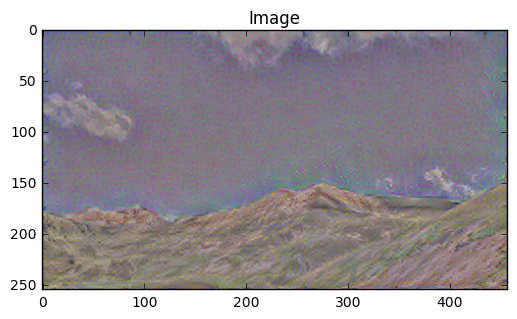

迭代: 800 ,loss: 10378.61914062


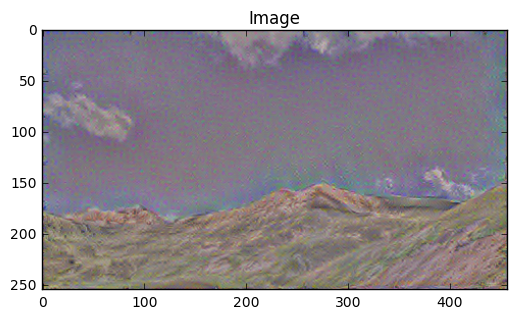

迭代: 900 ,loss: 9848.31640625


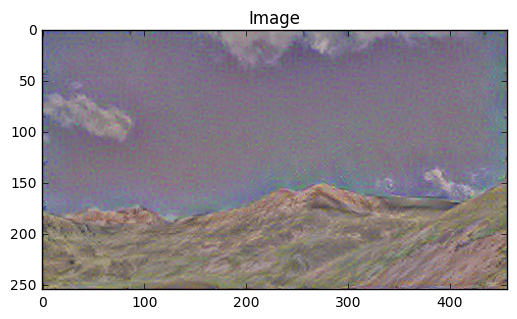

迭代: 1000 ,loss: 9409.72070312


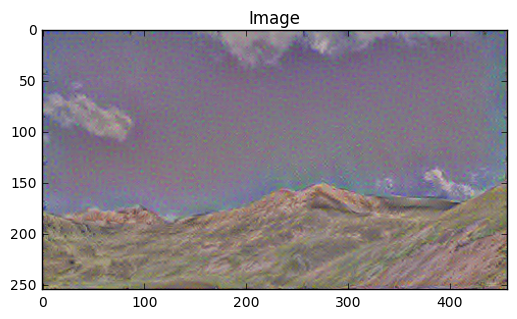

In [6]:
style_image=Image.open('shan-style.jpg')
style_image=np.array(style_image).astype(np.float32)-128.0
content_image=Image.open('shan.jpg')
content_image=np.array(content_image).astype(np.float32)-128.0
stylize(style_image,content_image,0.2,1000)

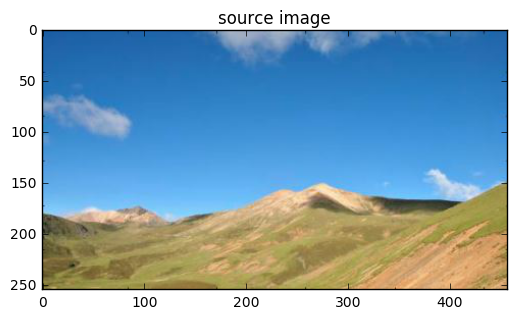

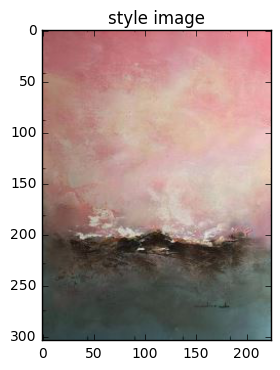

In [7]:
content_image=Image.open('shan.jpg')
plt.imshow(content_image)
plt.axis('on')
plt.title('source image')
plt.show()
style_image=Image.open('shan-style.jpg')
plt.imshow(style_image)
plt.axis('on')
plt.title('style image')
plt.show()